In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *

from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})


In [2]:
import fsps
import sedpy
import prospect
import emcee
import astropy
import math
from astropy.cosmology import WMAP9

In [3]:
def build_obs(snr=10, **extras):
    from prospect.utils.obsutils import fix_obs
    import sedpy

    obs = {}
    
    twomass = ['twomass_{}'.format(b) for b in ['J', 'H', 'Ks']]
    sdss = ['sdss_{0}0'.format(b) for b in ['u', 'g', 'r', 'i', 'z']]
    
    filternames = twomass + sdss
    
    obs["filters"] = sedpy.observate.load_filters(filternames)

    M_AB = np.array([16.14, 15.83, 15.97, 20.22, 18.45, 17.07, 16.56, 16.22])
    M_AB_unc = ([0.14, 0.18, 0.16, 0.13, 0.02, 0.01, 0.01, 0.01])

    mags = 10**(-0.4*M_AB)

    mag_down = [x-y for (x,y) in zip(M_AB, M_AB_unc)]
    flux_down = [10**(-0.4*x) for x in mag_down]
    flux_uncertainty = [y-x for (x,y) in zip(mags, flux_down)]
    
    obs['maggies'] = np.array(mags)
    obs['maggies_unc'] = np.array(flux_uncertainty)


    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    # and *False* for values you want to ignore.  Here we ignore the spitzer bands.
    #obs["phot_mask"] = np.array(['sdss' not in f.name for f in obs["filters"]])

    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    obs["wavelength"] = None
    
    obs["spectrum"] = None
    
    obs['unc'] = None
    
    obs['mask'] = None

    obs = fix_obs(obs)

    return obs

In [4]:
run_params = {}
run_params["snr"] = 10.0

Obs Dictionary Keys:

dict_keys(['maggies', 'filternames', 'ndof', 'mask', 'maggies_unc', 'spectrum', 'logify_spectrum', 'phot_wave', 'phot_mask', 'filters', 'wavelength', 'unc'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(twomass_J), <class 'sedpy.observate.Filter'>(twomass_H), <class 'sedpy.observate.Filter'>(twomass_Ks), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0)]
[0.000e+00 3.000e-04 4.000e-04 3.000e-04 9.000e-04 3.300e-03 1.010e-02
 3.370e-02 8.220e-02 1.497e-01 2.359e-01 3.166e-01 3.683e-01 4.075e-01
 4.078e-01 3.686e-01 3.838e-01 3.751e-01 3.806e-01 3.747e-01 3.686e-01
 3.610e-01 3.494e-01 3.409e-01 2.055e-01 3.235e-01 3.147e-01 3.051e-01
 2.955e-01 2.882e-01 2.861e-01 2.873e-01 2.842e-01 2.705e-01 2.379e-01
 1.655e-01 8.830e-02 3.700e-02 1.150e-02 4.700e-03 2.000e-03 1.000e-03
 9.000e-04 5.00

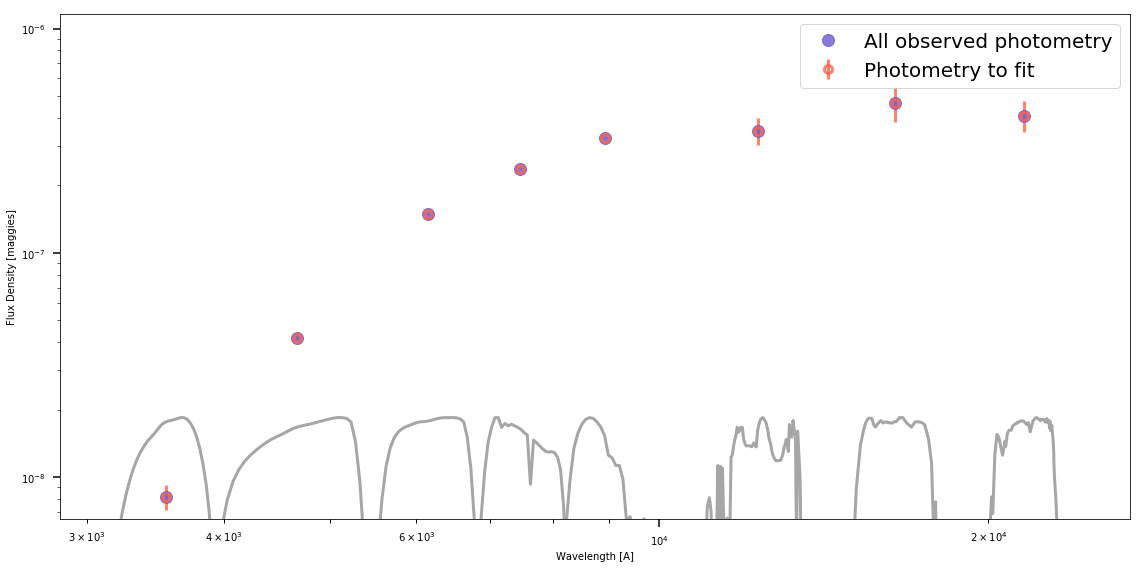

In [5]:
obs = build_obs(**run_params)

# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])
#print(obs['phot_mask'])
# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
figure(figsize=(16,8))

# plot all the data
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
mask = obs["phot_mask"]
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
print(obs['filters'][-2].transmission)
print(obs['filters'][-2].wavelength)
# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()

In [6]:
from prospect.models import priors
from prospect.models.templates import TemplateLibrary

In [7]:
def build_model(object_redshift=0.225, fixed_metallicity=None, add_nebular=True, add_dust=False, 
                **extras):

    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors


    model_params = TemplateLibrary["parametric_sfh"]
    
  
    # Let's make some changes to initial values appropriate for our objects and data
    #model_params["zred"]["init"] = 0.0
    model_params["dust2"]["init"] = 0.00
    #model_params["logzsol"]["init"] = 0.01
    #model_params["tage"]["init"] = 9.
    #model_params["mass"]["init"] = 9e11
    model_params["imf_type"]["init"] = 1
    model_params["dust_type"]["init"] = 1 
    
    model_params["dust2"]["prior"] = priors.TopHat(mini=-0.1, maxi=2.0)
    model_params["tau"]["prior"] = priors.LogUniform(mini=0.1, maxi=10)
    model_params["tage"]["prior"] = priors.TopHat(mini=0.0, maxi=11.008)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e9, maxi=1e14)
    model_params["logzsol"]["prior"] = priors.TopHat(mini=-1.5,maxi=0.2)

    #model_params["mass"]["disp_floor"] = 1e5
    #model_params["tau"]["disp_floor"] = 1.0
    #model_params["tage"]["disp_floor"] = 1.0
    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        # make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    if add_nebular:
        model_params.update(TemplateLibrary["nebular"])
        
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SedModel(model_params)

    return model


run_params["object_redshift"] = 0.225
run_params["fixed_metallicity"] = None
run_params["add_nebular"] = True

In [8]:
model = build_model(**run_params)
print(model)
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(maxi=100000000000000.0,mini=1000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(maxi=0.2,mini=-1.5)
  tau: <class 'prospect.models.priors.LogUniform'>(maxi=10,mini=0.1)
  tage: <class 'prospect.models.priors.TopHat'>(maxi=11.008,mini=0.0)
  dust2: <class 'prospect.models.priors.TopHat'>(maxi=2.0,mini=-0.1)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  dust_type: 1 
  zred: 0.225 
  gas_logu: -2.0 
  imf_type: 1 
  nebemlineinspec: True 
  add_neb_continuum: True 
  add_neb_emission: True 
  sfh: 4 
  gas_logz: 0.0 <function stellar_logzsol at 0x7fe66dab60d0>

Initial free parameter vector theta:
  [ 1.e+10 -5.e-01  1.e+00  1.e+00  0.e+00]

Initial parameter dictionary:
{'dust_type': array([1]), 'mass': array([1.e+10]), 'zred': array([0.225]), 'gas_logu': array([-2.]), 'logzsol': array([-0.5]), 'tau': array([1]

In [9]:
def build_sps(zcontinuous=1, **extras):
    
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

In [10]:
sps = build_sps(**run_params)

In [11]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

verbose = False
def lnprobfn(theta, model=None, obs=None, sps=None, 
             nested=True, verbose=verbose):

    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    spec, phot, mfrac = model.mean_model(theta, obs, sps=sps)
 
    # Calculate likelihoods
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)

    return lnp_prior + lnp_phot + lnp_spec

run_params["verbose"] = verbose

In [12]:
from prospect.likelihood import chi_spec, chi_phot
def chivecfn(theta):

    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return np.zeros(model.ndim) - np.infty

    # Generate mean model
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return np.zeros(model.ndim) - np.infty

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    return np.concatenate([chispec, chiphot])

In [13]:
from prospect.fitting import lnprobfn
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

print(sps.ssp.libraries)

from prospect.fitting import fit_model

(b'mist', b'miles')


In [14]:
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 2

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))

/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/models/priors.py:90: RuntimeWarning: divide by zero encountered in log
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


Done optmization in 380.0818953514099s


In [15]:
run_params["dynesty"] = True
run_params["optmization"] = False
run_params["emcee"] = False
run_params["nested_method"] = "rwalk"
run_params["nested_bound"] = 'multi'
run_params["nlive_init"] = 400
run_params["nlive_batch"] = 200
run_params["nested_dlogz_init"] = 0.05
run_params["nested_posterior_thresh"] = 0.05
run_params["nested_maxcall"] = int(1e7)

In [16]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done dynesty in {0}s'.format(output["sampling"][1]))

/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/models/priors.py:90: RuntimeWarning: divide by zero encountered in log
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/fitting/nested.py:76: RuntimeWarning: invalid value encountered in sqrt
iter: 4429 | batch: 6 | nc: 7 | ncall: 22399 | eff(%): 19.362 | loglstar: 122.270 < 128.647 < 127.181 | logz: 114.418 +/-  0.334 | stop:  1.028     

done dynesty in 1444.2566876411438s


In [17]:
from prospect.io import write_results as writer
hfile = "050509b_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:52: RuntimeWarning: Could not store paramfile text
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:225: RuntimeWarning: Could not JSON serialize model_params, pickled instead
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:254: UserWarning: Could not JSON serialize ndof, pickled instead


In [18]:
import prospect.io.read_results as reader
results_type = "dynesty"
result, obs, _ = reader.results_from("050509b_mcmc.h5".format(results_type), dangerous=False)
print(result.keys())

dict_keys(['logz', 'model', 'information', 'logzerr', 'niter', 'samples_id', 'model_params', 'sampling_duration', 'logvol', 'lnprobability', 'lnlikelihood', 'ncall', 'theta_labels', 'paramfile_text', 'weights', 'prospector_version', 'efficiency', 'chain', 'optimization_results', 'obs', 'run_params', 'optimizer_duration'])


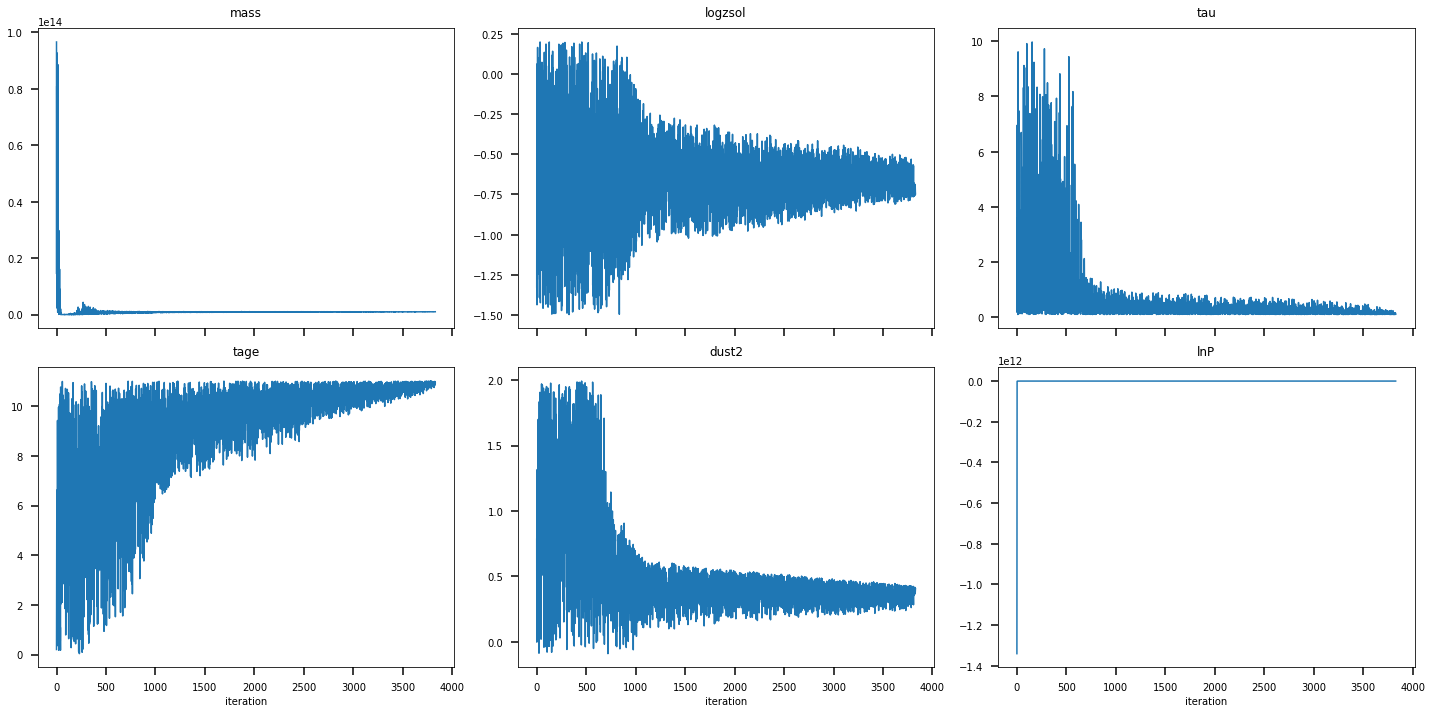

In [19]:
tracefig = reader.traceplot(result, figsize=(20,10))

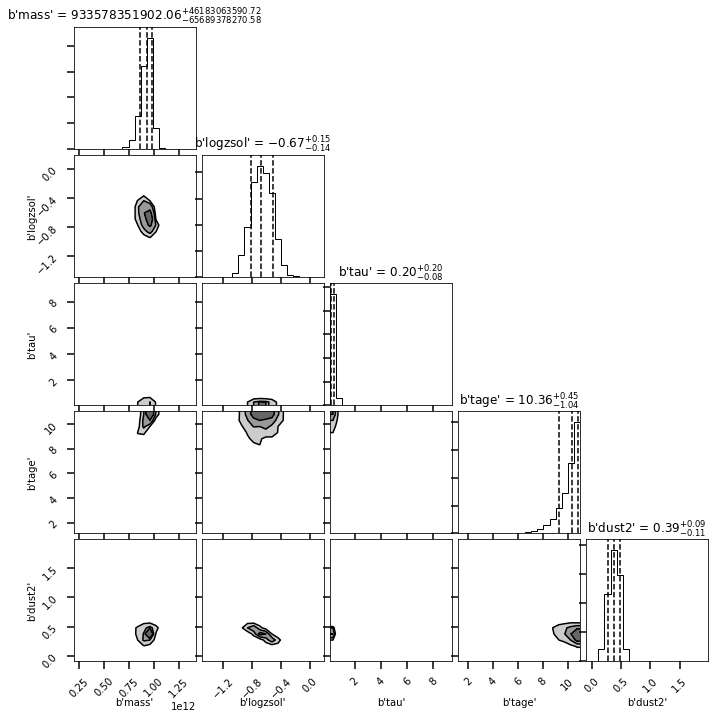

In [20]:
result, obs, model = reader.results_from("050509b_mcmc.h5")
imax = np.argmax(result['lnprobability'])

# The theta_max values give the most probable vales
theta_max = result['chain'][imax, :].copy()

# We start our corner plots 500 iterations in, as the iterations before this usually have nonsensical/ low 
# probability values
cornerfig = reader.subcorner(result, start=500, thin=1,
                      fig=subplots(5,5,figsize=(10,10))[0], fontsize=100)

In [21]:
sps = build_sps(**run_params)
model = build_model(**run_params)

flatchain = result['chain']

from prospect.utils.plotting import quantile
post_pcts = [quantile(flatchain[:, i], percents=50, weights=result.get("weights", None))
             for i in range(model.ndim)]

# These should have all the converged values
print(post_pcts)

mspec_conv, mphot_conv, _ = model.mean_model(post_pcts, obs, sps=sps)
print(mphot_conv)




[933495059245.2864, -0.6683579214993033, 0.20448140941405138, 10.361646729613392, 0.3865885087178071]
[4.92970877e-07 5.77350136e-07 6.35834959e-07 7.28092348e-09
 4.18031897e-08 1.42953374e-07 2.29132117e-07 3.15226898e-07]


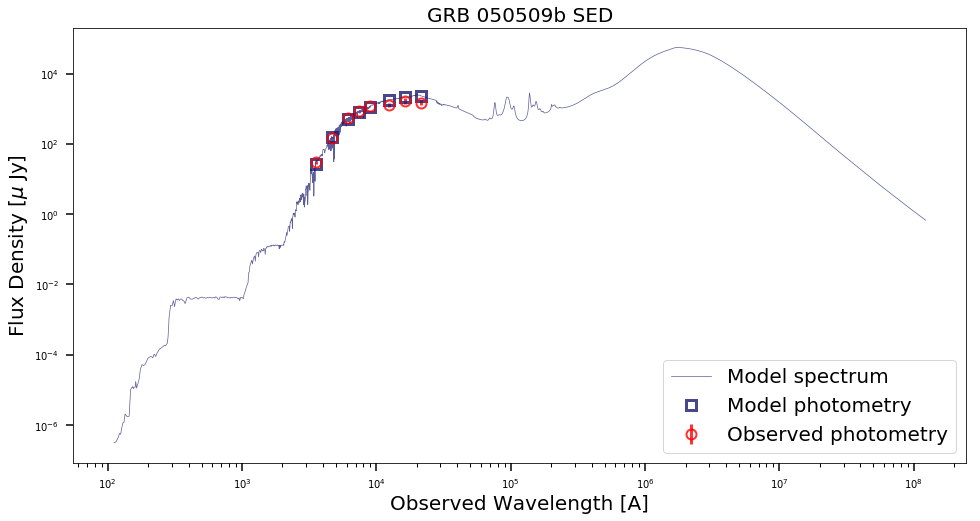

In [22]:
import matplotlib.pyplot as plt
wphot = obs["phot_wave"]

a = 1 + model.params.get('zred') 

# Spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths.copy()
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]


maggies = obs['maggies']
mags_unc = obs['maggies_unc']

# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec_conv*3631*1e6, label='Model spectrum',
       lw=0.7, color='midnightblue', alpha=0.7)
plt.errorbar(wphot, mphot_conv*3631*1e6, label='Model photometry',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='midnightblue', markeredgewidth=3)
plt.errorbar(wphot, obs['maggies']*3631*1e6, yerr=obs['maggies_unc']*3631*1e6, 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=2)
    



plt.xlabel('Observed Wavelength [A]',fontsize =20)
plt.ylabel(r'Flux Density [$\mu$ Jy]',fontsize =20)
plt.title('GRB 050509b SED',fontsize =20)

plt.legend(loc='best', fontsize=20)

plt.show()

